In [1]:
# Specify the path to your CSV file containing NIFTI paths
input_csv_path = '/Users/cu135/Partners HealthCare Dropbox/Calvin Howard/resources/datasets/TMS-DBS_studies_alzheimers/metadata/secondary_list.csv'
sheet = None #'master_list_proper_subjects' ?

In [2]:
from calvin_utils.permutation_analysis_utils.statsmodels_palm import CalvinStatsmodelsPalm
# Instantiate the PalmPrepararation class
cal_palm = CalvinStatsmodelsPalm(input_csv_path=input_csv_path, output_dir=None, sheet=sheet)
# Call the process_nifti_paths method
data_df = cal_palm.read_and_display_data()
data_df

,Study,DOI,RCT_Design,Age_range,CDR,Active_N,Sham_N,Mean_Age,Active_Age,Shame_Age,...,Included,Exclusion_Reason,Subject,roi_path,all_flipped_all_datasets_weighted_r_map_pcc_inverse_r_map_spatial_corr,all_flipped_all_datasets_weighted_r_map_pcc_inverse_r_map_cosine,all_flipped_all_datasets_weighted_r_map_pcc_inverse_r_map_sum,all_flipped_all_datasets_weighted_r_map_pcc_inverse_r_map_average_subject_in_target,all_flipped_all_datasets_weighted_r_map_pcc_inverse_r_map_average_target_in_subject,all_flipped_all_datasets_weighted_r_map_pcc_inverse_r_map_num_in_roi
0,"Cotelli et al., 2011",10.1136/jnnp.2009.197848,Parallel,NaN,NaN,5,5.0,71,71.2 ± 6.1,74.4 ± 3.8,...,NaN,NaN,Cotelli_et_al___2011,/Users/cu135/Partners HealthCare Dropbox/Calvi...,-0.006870,-0.006933,-3.384964,-0.000023,-0.483566,0
1,"Hu et al., 2022",10.1016/j.brs.2022.11.009,Parallel,60–90,2,21,21.0,76,76.86 ± 6.07,75.33 ± 5.73,...,NaN,NaN,Hu_et_al___2022,/Users/cu135/Partners HealthCare Dropbox/Calvi...,0.007772,0.007681,5.110515,0.000035,0.393117,0
2,"Jia et al., 2021",10.3389/fnagi.2021.693611,Parallel,55–85,0.5–2,35,34.0,71,71.41 ± 8.85,73.41 ± 7.73,...,NaN,NaN,Jia_et_al___2021,/Users/cu135/Partners HealthCare Dropbox/Calvi...,0.008853,0.008785,4.289160,0.000029,0.612737,0
3,"Jung et al., 2025",10.1001/jamanetworkopen.2024.9220,Parallel,55-90,0.5-2,18,12.0,69,69.8 ± 9.1,69.8 ± 9.1,...,NaN,NaN,Jung_et_al___2025,/Users/cu135/Partners HealthCare Dropbox/Calvi...,0.008755,0.008688,4.241653,0.000029,0.605950,0
4,"Koch et al., 2022",10.1093/brain/awac285,Parallel,50–85,0.5–1,25,25.0,75,75 ± 5.6,72.3 ± 7.2,...,NaN,NaN,Koch_et_al___2022,/Users/cu135/Partners HealthCare Dropbox/Calvi...,0.008367,0.008299,4.051832,0.000028,0.578833,0
5,"Kuhn et al., 2015",https://doi.org/10.1038/mp.2014.32,Crossover,57-90,0.5–1,6,NaN,69,69.5 ± 7.7,NaN,...,NaN,NaN,Kuhn_et_al___2015,/Users/cu135/Partners HealthCare Dropbox/Calvi...,0.001355,0.001263,0.871995,0.000006,0.062285,0
6,"Li et al., 2021",10.1016/j.brs.2021.01.012,Parallel,NaN,NaN,37,38.0,65,65.97 ± 8.47,64.58 ± 7.88,...,NaN,NaN,Li_et_al___2021,/Users/cu135/Partners HealthCare Dropbox/Calvi...,-0.008690,-0.008753,-4.273216,-0.000029,-0.610459,0
7,"Liu et al., 2022",10.1093/cercor/bhab371,Parallel,50–85,0.5–1,25,12.0,67,67.28 ± 7.74,72.08 ± 7.3,...,NaN,NaN,Liu_et_al___2022,/Users/cu135/Partners HealthCare Dropbox/Calvi...,0.004518,0.004428,2.946101,0.000020,0.226623,0
8,"Lozano et al., 2016",https://doi.org/10.3233/JAD-160017,Parallel,>65,0.5,30,15.0,69,69.8 ± 8.1,67.8 ± 7.7,...,NaN,NaN,Lozano_et_al___2016,/Users/cu135/Partners HealthCare Dropbox/Calvi...,0.009360,0.009272,6.843548,0.000047,0.526427,0
9,"Moussavi et al., 2024",10.1016/j.neurot.2024.e00331,Parallel,>55,1∼2,53,51.0,73,73.3 ± 6.9,75 ± 9.1,...,NaN,NaN,Moussavi_et_al___2024,/Users/cu135/Partners HealthCare Dropbox/Calvi...,-0.006423,-0.006503,-3.979838,-0.000027,-0.361803,0



# 01 - Preprocess Your Data

**Handle NANs**
- Set drop_nans=True is you would like to remove NaNs from data
- Provide a column name or a list of column names to remove NaNs from

In [ ]:
len(data_df['study'].unique())

In [ ]:
data_df.columns

In [ ]:
drop_list = ['all_flipped_all_datasets_weighted_r_map_pcc_inverse_r_map_average_target_in_subject', 'Overall_Cognition_Cohen_s_D']

In [ ]:
data_df = cal_palm.drop_nans_from_columns(columns_to_drop_from=drop_list)
data_df

**Drop Row Based on Value of Column**

Define the column, condition, and value for dropping rows
- column = 'your_column_name'
- condition = 'above'  # Options: 'equal', 'above', 'below'

Set the parameters for dropping rows

In [ ]:
data_df.columns

In [ ]:
data_df.Disease.unique()

In [ ]:
column = 'Memory_Specific'  # The column you'd like to evaluate
condition = 'equal'  # Thecondition to check ('equal', 'above', 'below', 'not')
value = 0 # The value to compare against

In [ ]:
data_df, other_df = cal_palm.drop_rows_based_on_value(column, condition, value)
data_df

In [ ]:
data_df_sorted = data_df.sort_values(by='Location')
data_df_sorted

Regress out Covariates

In [ ]:
data_df.columns

In [ ]:
dependent_variable_list = ['Pre_Post_Memory_Effect_Size__Cohen_s_D_']
regressors = ['Disease', 'Years_Between_Measurements', 'Mean_Age', 'Closed_Loop']

In [ ]:
#Impute covariates in if desired
for col in regressors:
    if data_df[col].dtype == 'O':  # object/categorical
        data_df[col] = data_df[col].fillna(data_df[col].mode()[0])
    else:  # numeric
        data_df[col] = data_df[col].fillna(data_df[col].mean())
data_df[regressors].isna().sum()

In [ ]:
from calvin_utils.statistical_utils.regression_utils import RegressOutCovariates
data_df, adjusted_dep_vars_list = RegressOutCovariates.run(df=data_df, dependent_variable_list=dependent_variable_list, covariates_list=regressors)
print(adjusted_dep_vars_list)

**Standardize Data**
- Enter Columns you Don't want to standardize into a list

In [ ]:
data_df.columns

In [ ]:
# Remove anything you don't want to standardize
cols_not_to_standardize = ['TOTAL11']

In [ ]:
# data_df = cal_palm.standardize_columns(cols_not_to_standardize)

Do Miscellaneous Data Cleaning

In [ ]:
# data_df = data_df[(data_df['Pre_Post_Memory_Effect_Size__Cohen_s_D_'] >= -1) & (data_df['Pre_Post_Memory_Effect_Size__Cohen_s_D_'] <= 1)]

In [4]:
data_df.columns

Index(['Study', 'DOI', 'RCT_Design', 'Age_range', 'CDR', 'Active_N', 'Sham_N',
       'Mean_Age', 'Active_Age', 'Shame_Age', 'Active_M_F', 'Sham_M_F',
       'Active_Education__Yrs_', 'Sham_Education__Yrs_', 'Active_AD_Treatment',
       'Diagnosis', 'Diagnostic_Criteria', 'Stim_Type', 'Frequency',
       'Intensity', 'Navigation', 'Total_Pulses_session', 'session',
       'Total_pulses', 'Overall_Cognition_Test', 'Overall_Cognition_Cohen_s_D',
       'Verbal_Memory_Test', 'Verbal_Memory_Cohen_s_D', 'Stimulation_site',
       'Stim_Coordinate', 'Included', 'Exclusion_Reason', 'Subject',
       'roi_path',
       'all_flipped_all_datasets_weighted_r_map_pcc_inverse_r_map_spatial_corr',
       'all_flipped_all_datasets_weighted_r_map_pcc_inverse_r_map_cosine',
       'all_flipped_all_datasets_weighted_r_map_pcc_inverse_r_map_sum',
       'all_flipped_all_datasets_weighted_r_map_pcc_inverse_r_map_average_subject_in_target',
       'all_flipped_all_datasets_weighted_r_map_pcc_inverse_r_map

In [10]:
import numpy as np
data_df['spcorr_sign'] = np.where(data_df['all_flipped_all_datasets_weighted_r_map_pcc_inverse_r_map_average_target_in_subject'] > 0, 'Positive', 'Negative')


# A - Simple BoxPLot

In [11]:
category_col = 'spcorr_sign'
y_col = 'Overall_Cognition_Cohen_s_D'

In [12]:
out_dir = '/Users/cu135/Library/CloudStorage/OneDrive-Personal/OneDrive_Documents/Academia/Research/2023/ccm_memory/Figures/explaining_prior_targets_alzheimer'

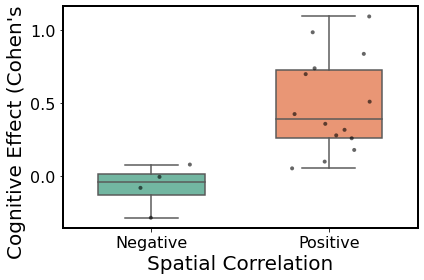

In [16]:
from calvin_utils.statistical_utils.boxplot import BoxJitterPlotter
bjp = BoxJitterPlotter(figsize=(6,4))
bjp.plot(data_df, group_col=category_col, y_col=y_col, title='', out_dir=out_dir, xlabel='Spatial Correlation', ylabel="Cognitive Effect (Cohen's D)")

# B - Horizontal Box Plot
- Import a CSV with labels in the first column and observations across the other columns. Each row gets a boxplot. 

In [ ]:
data_path =''

In [ ]:
import pandas as pd
df = pd.read_csv(data_path)

In [ ]:
from calvin_utils.statistical_utils.boxplot import plot_horizontal_boxplot_with_stats
plot_horizontal_boxplot_with_stats(
    df,
    xlabel="x",
    out_dir=out_dir
)

Simple boxplot from CSV